## ARF Evaluations

In [1]:
from prequential import run_prequential

from skmultiflow.meta import AdaptiveRandomForestClassifier
from skmultiflow.drift_detection.adwin import ADWIN

from float.feature_selection import FIRES, OFS           # online feature methods
from skmultiflow.data import FileStream                 # create stream from file

import pandas as pd
import csv
import matplotlib.pyplot as plt

In [2]:
data_loader = FileStream(filepath='../merged_cesnet.csv')

In [3]:
ref_sample, _ = data_loader.next_sample(50)
data_loader.reset()             

In [4]:
arf_params = {
    'n_estimators': 6,
    'max_features': "auto",
    'drift_detection_method': None,
    'warning_detection_method': None,
    'grace_period': 25,
    'split_criterion': "gini",
    'split_confidence': 0.01,
    'tie_threshold': 0.01,
    'leaf_prediction': "nba"
}

fires_params = {
    'penalty_s': 0.1,
    'penalty_r': 1,
    'lr_mu': 0.025,
    'lr_sigma': 0.1,
    'n_total_features': data_loader.n_features,
    'n_selected_features': 10,
    'classes': data_loader.target_values,
    'baseline': "gaussian",
    'ref_sample': ref_sample
}

ofs_params = {
    'n_selected_features': 5,
    'n_total_features': data_loader.n_features,
    'baseline': "gaussian",
    'ref_sample': ref_sample    
}

### Without ADWIN

In [ ]:
data_loader.restart()

# no feature selection
print("EVALUATING: ARF")
accuracy, precision, recall, f1, auc, avg_processing_time, _ = run_prequential(
    classifier=AdaptiveRandomForestClassifier(**arf_params), 
    stream=data_loader, 
    feature_selector=None, 
    drift_detection=None, 
    preq_samples=20000
)
print(f"Accuracy: {accuracy:.6f}, Precision: {precision:.6f}, Recall: {recall:.6f}, F1: {f1:.6f}, AUC: {auc:.6f}")
print(f"Average processing time: {avg_processing_time}")

data_loader.restart()

new_arf_params = arf_params.copy()
new_arf_params.update({'max_features': None})

# FIRES
print("EVALUATING: ARF + FIRES")
accuracy, precision, recall, f1, auc, avg_processing_time, _, _, _ = run_prequential(
    classifier=AdaptiveRandomForestClassifier(**new_arf_params),
    stream=data_loader, 
    feature_selector=FIRES(**fires_params), 
    drift_detection=None, 
    preq_samples=20000
)
print(f"Accuracy: {accuracy:.6f}, Precision: {precision:.6f}, Recall: {recall:.6f}, F1: {f1:.6f}, AUC: {auc:.6f}")
print(f"Average processing time: {avg_processing_time}")

data_loader.restart()

# OFS
print("EVALUATING: ARF + OFS")
accuracy, precision, recall, f1, auc, avg_processing_time, _, _, _ = run_prequential(
    classifier=AdaptiveRandomForestClassifier(**new_arf_params), 
    stream=data_loader, 
    feature_selector=OFS(**ofs_params), 
    drift_detection=None, 
    preq_samples=20000
)
print(f"Accuracy: {accuracy:.6f}, Precision: {precision:.6f}, Recall: {recall:.6f}, F1: {f1:.6f}, AUC: {auc:.6f}")
print(f"Average processing time: {avg_processing_time}")

### With ADWIN

EVALUATING: ARF + ADWIN
Accuracy: 0.999140, Precision: 0.999131, Recall: 0.999431, F1: 0.999281, AUC: 0.999696
Average processing time: 0.0039702816380000365
[289, 10142, 12316, 15393, 20245, 20372, 21157, 29319, 30179, 30191, 30249, 31178, 45674, 50176, 50177, 50195]


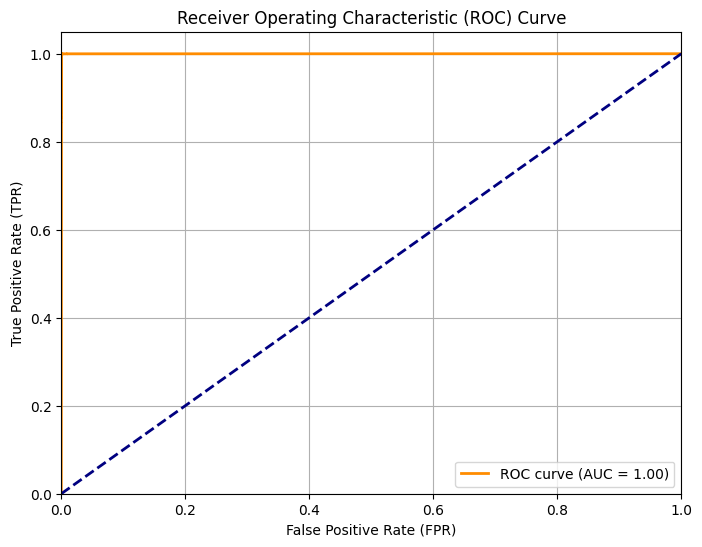

EVALUATING: ARF + ADWIN + FIRES



ValueError: Only one class present in y_true. ROC AUC score is not defined in that case.

In [ ]:
data_loader.restart()

new_arf_params = arf_params.copy()
new_arf_params.update({'drift_detection_method': ADWIN(0.9), 'warning_detection_method': ADWIN(0.7)})

# no feature selection
print("EVALUATING: ARF + ADWIN")
accuracy, precision, recall, f1, auc, fpr, tpr, avg_processing_time, drift_idx_list = run_prequential(
    classifier=AdaptiveRandomForestClassifier(**new_arf_params), 
    stream=data_loader, 
    feature_selector=None, 
    drift_detection=ADWIN(), 
    preq_samples=50000
)
print(f"Accuracy: {accuracy:.6f}, Precision: {precision:.6f}, Recall: {recall:.6f}, F1: {f1:.6f}, AUC: {auc:.6f}")
print(f"Average processing time: {avg_processing_time}")
print(drift_idx_list)

data_loader.restart()

new_arf_params = arf_params.copy()
new_arf_params.update({'max_features': None, 'drift_detection_method': ADWIN(0.9), 'warning_detection_method': ADWIN(0.7)})

# FIRES
print("EVALUATING: ARF + ADWIN + FIRES")
accuracy, precision, recall, f1, auc, fpr, tpr, avg_processing_time, selection_history, weights_history, drift_idx_list = run_prequential(
    classifier=AdaptiveRandomForestClassifier(**new_arf_params),
    stream=data_loader, 
    feature_selector=FIRES(**fires_params), 
    drift_detection=ADWIN(), 
    preq_samples=data_loader.n_remaining_samples()
)
print(f"Accuracy: {accuracy:.6f}, Precision: {precision:.6f}, Recall: {recall:.6f}, F1: {f1:.6f}, AUC: {auc:.6f}")
print(f"Average processing time: {avg_processing_time}")
print(drift_idx_list)
with open('sel_features_fires.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerows(selection_history)
with open('weights_fires.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerows(weights_history)

data_loader.restart()

# OFS
print("EVALUATING: ARF + ADWIN + OFS")
accuracy, precision, recall, f1, auc, fpr, tpr, avg_processing_time, selection_history, weights_history, drift_idx_list = run_prequential(
    classifier=AdaptiveRandomForestClassifier(**new_arf_params),
    stream=data_loader, 
    feature_selector=OFS(**ofs_params), 
    drift_detection=ADWIN(), 
    preq_samples=data_loader.n_remaining_samples()
)
print(f"Accuracy: {accuracy:.6f}, Precision: {precision:.6f}, Recall: {recall:.6f}, F1: {f1:.6f}, AUC: {auc:.6f}")
print(f"Average processing time: {avg_processing_time}")
print(drift_idx_list)
with open('sel_features_ofs.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerows(selection_history)
with open('weights_ofs.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerows(weights_history)